In [1]:
IndexToRep[n_]:= IndexToRep[n] = Module[{j, m},
	j = Floor[Sqrt[n - 1]];
	m = n - 1 - j^2 - j;
	{j, m}
]

RepToIndex[j_, m_]:= RepToIndex[j, m] = j^2 + m + j + 1;

IndexToRepSortedBym[n_]:= 
	IndexToRepSortedBym[n] = Sort[IndexToRep[n], #1[[2]] < #2[[2]] &]
	
ApproximateByProjection[mat_]:= Module[{u,w,v},
	{u, w, v} = SingularValueDecomposition[mat];
	Return[u . DiagonalMatrix[If[Re[#] > 0.5, 1., 0.] &/@ Diagonal[w]] . ConjugateTranspose[v]];
]

ProjInfinity[r1_, r2_, angle_?NumericQ]:= Block[
	{\[Theta], \[Phi]},
	If[
		Last[r1]!=Last[r2],
		0.,
		NIntegrate[
			Sin[\[Theta]]SphericalHarmonicY[First[r2],Last[r2], \[Theta], \[Phi]]SphericalHarmonicY[First[r1],Last[r1], \[Theta], -\[Phi]],
			{\[Theta],0,angle},{\[Phi],0,2Pi}, 
			Method -> {"GlobalAdaptive", "SymbolicProcessing" -> 0},
			WorkingPrecision -> 30
		]
	]
]

ProjInfinityExact[r1_, r2_, angle_?NumericQ]:= Block[
	{\[Theta], \[Phi]},
	If[
		Last[r1]!=Last[r2],
		0.,
		FullSimplify[
			Integrate[
				Sin[\[Theta]]SphericalHarmonicY[First[r2],Last[r2], \[Theta], \[Phi]]SphericalHarmonicY[First[r1],Last[r1], \[Theta], -\[Phi]],
				{\[Theta], 0, angle}, {\[Phi], 0, 2Pi}
			]
		]
	]
]

ProjInfinityGKrule[r1_, r2_, angle_?NumericQ]:= Block[
	{\[Theta], \[Phi]},
	If[
		Last[r1]!=Last[r2],
		0.,
		NIntegrate[
			Sin[\[Theta]]SphericalHarmonicY[First[r2],Last[r2],\[Theta],\[Phi]]SphericalHarmonicY[First[r1],Last[r1],\[Theta],-\[Phi]],
			{\[Theta], 0, angle},{\[Phi], 0, 2Pi}, 
			Method -> {"GaussKronrodRule", "SymbolicProcessing" -> 0},
			WorkingPrecision -> 30]
	]
]

ProjInfinityC[r1_, r2_, angle_?NumericQ]:= Block[
	{\[Theta], \[Phi]},
	If[
		Last[r1]!=Last[r2],
		0.0,
		NIntegrate[
			Sin[\[Theta]]SphericalHarmonicY[First[r2],Last[r2],\[Theta],\[Phi]]SphericalHarmonicY[First[r1],Last[r1],\[Theta],-\[Phi]],
			{\[Theta], 0, angle}, {\[Phi], 0, 2\[Pi]}, 
			Method -> {"GlobalAdaptive", Method -> "GaussKronrodRule", "SingularityDepth" -> Infinity},
			WorkingPrecision -> 30
		]
	]
]

ProjSorted[jmax_,angle_]:= Block[
	{ind = IndexToRep/@ Range[(jmax+1)^2], indSorted, overlap, M},
	overlap = Function[{r1,r2}, ProjInfinity[r1, r2, angle]];
	indSorted = Sort[ind, #1[[2]]<#2[[2]]&];
	M = Outer[overlap, indSorted, indSorted, 1];
	Chop[Re[ApproximateByProjection[M]]]
]

ProjSortedShort[jmax_,angle_]:= Block[
	{ind=IndexToRep/@Range[(jmax+1.)^2], indSorted, indexofjm0, indSortedUntiljmAre0, overlap, M},
	overlap = Function[{r1,r2}, ProjInfinityGKrule[r1, r2, angle]];
	indSorted = Sort[ind, #1[[2]]<#2[[2]]&];
	indexofjm0 = Total[Range[1,jmax+1]];
	indSortedUntiljmAre0 = indSorted[[1;;indexofjm0]];
	M = Outer[overlap, indSortedUntiljmAre0, indSortedUntiljmAre0, 1];
	Chop[Re[ApproximateByProjection[M]]]
]

ProjSortedShort[jmax_,angle_]:= Block[
	{ind=IndexToRep/@Range[(jmax+1.)^2], indSorted, indexofjm0, indSortedUntiljmAre0, overlap, M},
	overlap = Function[{r1,r2}, ProjInfinityGKrule[r1, r2, angle]];
	indSorted = Sort[ind, #1[[2]]<#2[[2]]&];
	indexofjm0 = Total[Range[1,jmax+1]];
	indSortedUntiljmAre0 = indSorted[[1;;indexofjm0]];
	M = Outer[overlap, indSortedUntiljmAre0, indSortedUntiljmAre0, 1];
	Chop[Re[ApproximateByProjection[M]]]
]

ProjSortedShortParallel[jmax_,angle_]:= Block[
	{ind=IndexToRep/@Range[(jmax+1.)^2], indSorted, indexofjm0, indSortedUntiljmAre0, overlap, M},
	overlap = Function[{r1,r2}, ProjInfinityGKrule[r1, r2, angle]];
	indSorted = Sort[ind, #1[[2]]<#2[[2]]&];
	indexofjm0 = Total[Range[1,jmax+1]];
	indSortedUntiljmAre0 = indSorted[[1;;indexofjm0]];
	M = Parallelize @ Outer[overlap, indSortedUntiljmAre0, indSortedUntiljmAre0, 1];
	Chop[Re[ApproximateByProjection[M]]]
]

In [14]:
runExperiment[index_, n_, a_]:= Block[
    {matPath, mat, fileKey},
    angles = Table[ArcCos[1 - k / (a - 0.5)], {k, 0, a - 1}];
    fileKey = "/home/ec2-user/SageMaker/spherical-harmonics/data/n_" <> ToString[n] <> "_a_" <>ToString[a] <> "_i_" <> ToString[index];
    matPathM = fileKey <> ".mat";
    matPathCsv = fileKey <> ".csv";
    mat = ProjSortedShortParallel[n-1, angles[[index]]];
    Export[matPathM, mat];
    Export[matPathCsv, mat]
]

In [15]:
n = 100;
a = 20;
angles = Table[ArcCos[1 - k / (a - 0.5)], {k, 0, a - 1}]

{0., 0.321641, 0.456874, 0.56207, 0.652, 0.732373, 0.806114, 0.874962, 0.940055, 
 
>   1.00219, 1.06194, 1.11976, 1.17601, 1.23096, 1.28486, 1.33793, 1.39033, 1.44224, 
 
>   1.4938, 1.54515}

{KernelObject[1, local], KernelObject[2, local], KernelObject[3, local], 
 
>   KernelObject[4, local], KernelObject[5, local], KernelObject[6, local], 
 
>   KernelObject[7, local], KernelObject[8, local]}
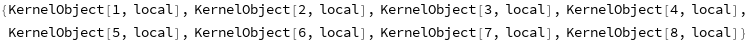

In [30]:
LaunchKernels[8]

In [16]:
ProjSortedShort[10, 0.456874] // AbsoluteTiming

{19.6435, {{0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [31]:
ProjSortedShortParallel[10, 0.456874] // AbsoluteTiming

{5.19341, {{0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [18]:
AbsoluteTiming@runExperiment[2, 5, 3]

{1.50803, /home/ec2-user/SageMaker/spherical-harmonics/data/n_5_a_3_i_2.csv}

In [ ]:
AbsoluteTiming@runExperiment[2, 10, 3]

In [19]:
IndexToRep[n_]:=IndexToRep[n]=Module[{j,m},
j=Floor[Sqrt[n-1]];
m=n-1-j^2-j;
Return[{j,m}];
];
RepToIndex[j_,m_]:=RepToIndex[j,m]=j^2+m+j+1;

ApproximateByProjection[mat_]:=Module[{u,w,v},
{u,w,v}=SingularValueDecomposition[mat];
Return[u . DiagonalMatrix[If[Re[#]>0.5,1,0]&/@Diagonal[w]] . ConjugateTranspose[v]];
];

ProjInfinity[r1_,r2_,angle_]:=ProjInfinity[r1,r2,angle]=Module[{\[Theta],\[Phi]},
Return[If[Last[r1]!=Last[r2],0.0,NIntegrate[Sin[\[Theta]]SphericalHarmonicY[First[r2],Last[r2],\[Theta],\[Phi]]Conjugate[SphericalHarmonicY[First[r1],Last[r1],\[Theta],\[Phi]]],{\[Theta],0,angle},{\[Phi],0,2Pi},AccuracyGoal->5, WorkingPrecision->40, PrecisionGoal->10]]]
];

ProjSortedShort[jmax_,angle_]:= ProjSortedShort[jmax,angle] = Module[{ind=IndexToRep/@Range[(jmax+1)^2],indSorted,indexofjm0,indSortedUntiljmAre0,overlap,M},
overlap=Function[{r1,r2},ProjInfinity[r1,r2,angle]];
indSorted = Sort[ind,#1[[2]]<#2[[2]]&];
indexofjm0 = Total[Range[1,jmax+1]];
indSortedUntiljmAre0 = indSorted[[1;;indexofjm0]];
M=Outer[overlap,indSortedUntiljmAre0,indSortedUntiljmAre0,1];
Return[Chop[Re[ApproximateByProjection[M]]]];
];

In [24]:
runExperimentOriginal[index_, n_, a_]:= Block[
    {matPath, mat, fileKey},
    angles = Table[ArcCos[1 - k / (a - 0.5)], {k, 0, a - 1}];
    mat = ProjSortedShort[n-1, angles[[index]]]
]

In [25]:
{t, res} = AbsoluteTiming[runExperimentOriginal[2,5,3]]

{100.708, {{0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0.543632, 0.4416, 0.230404, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0.4416, 0.358718, 0.18716, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0.230404, 0.18716, 0.0976506, 0, 0, 0, 0, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0.233254, 0.29408, 0.26348, 0.151466, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0.29408, 0.370767, 0.332187, 0.190964, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0.26348, 0.332187, 0.297622, 0.171094, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0.151466, 0.190964, 0.171094, 0.0983565, 0, 0, 0, 0, 0}, 
 
>    {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0426486, 0.0827076, 0.114752, 0.120081, 
 
>     0.0800109}, {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0827076, 0.160393, 0.222536, 0.23287, 
 
>     0.155164}, {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.114752, 0.222536, 0.308756, 0.323094, 
 
>     0.21528}, {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.120081, 0.23287, 0.323094, 0.338098, 
 
>     0.225278}, {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0800109, 0.155164, 0.21528, 0.225278, 
 
>     0.150105}}}

In [29]:
wenzhenOptimize = Import["/home/ec2-user/SageMaker/spherical-harmonics/data/n_5_a_3_i_2.csv"];

In [30]:
wenzhenOptimize == res

True